In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import re
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import StratifiedKFold
%matplotlib inline
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_val_predict, GridSearchCV
import xgboost as xgb
import catboost
import lightgbm as lgb

In [20]:
data = pd.read_csv('train_0irEZ2H.csv')

In [21]:
data.head()

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52


In [22]:
data.isnull().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [23]:
# Replacing null value with mean and converting date to datetime format
data.fillna({'total_price':data['total_price'].mean()}, inplace=True)
data['week'] =  pd.to_datetime(data['week'], format='%d/%m/%y')

In [24]:
# Feature engineering

def data_prep(data):
     
    # Date time features
    data['Year'] = pd.to_datetime(data['week']).dt.year
    data['Month'] = pd.to_datetime(data['week']).dt.month
    data['Day'] = pd.to_datetime(data['week']).dt.day
    data['Dayofweek'] = pd.to_datetime(data['week']).dt.dayofweek
    data['DayOfyear'] = pd.to_datetime(data['week']).dt.dayofyear
    data['Week'] = pd.to_datetime(data['week']).dt.week 
    data['Quarter'] = pd.to_datetime(data['week']).dt.quarter  
    data['Is_month_start'] = pd.to_datetime(data['week']).dt.is_month_start 
    data['Is_month_end'] = pd.to_datetime(data['week']).dt.is_month_end 
    data['Is_quarter_start'] = pd.to_datetime(data['week']).dt.is_quarter_start
    data['Is_quarter_end'] = pd.to_datetime(data['week']).dt.is_quarter_end 
    data['Is_year_start'] = pd.to_datetime(data['week']).dt.is_year_start 
    data['Is_year_end'] = pd.to_datetime(data['week']).dt.is_year_end
    data.drop('week', inplace=True, axis=1)
    
    # Price difference rate
    data['price_diff_base'] = (data['base_price'] - data['total_price'])/data['base_price']
    data['price_diff_total'] = (data['total_price'] - data['base_price'])/data['total_price'] 
    
    # Mean total price and base price of every product
    new_df = data.groupby('sku_id').mean().reset_index()
    new_df = new_df[['sku_id', 'total_price', 'base_price']]
    new_df.columns = ['sku_id', 'total_price_mean_skuid', 'base_price_mean_skuid']
    data = pd.merge(data, new_df, on='sku_id', how='left')
    
    # Mean price difference rate
    data['mean_price_diff_base'] = (data['base_price_mean_skuid'] - data['base_price'])/data['base_price_mean_skuid']
    data['price_diff_total'] = (data['total_price_mean_skuid'] - data['total_price'])/data['total_price_mean_skuid']
    
    return data

In [25]:
data = data_prep(data)

In [26]:
# Data after feature engineering
data.head()

,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,Year,Month,...,Is_month_end,Is_quarter_start,Is_quarter_end,Is_year_start,Is_year_end,price_diff_base,price_diff_total,total_price_mean_skuid,base_price_mean_skuid,mean_price_diff_base
0,1,8091,216418,99.0375,111.8625,0,0,20,2011,1,...,False,False,False,False,False,0.11465,-0.076697,91.982702,94.688268,-0.181377
1,2,8091,216419,99.0375,99.0375,0,0,28,2011,1,...,False,False,False,False,False,0.00000,-0.072424,92.349162,94.908763,-0.043502
2,3,8091,216425,133.9500,133.9500,0,0,19,2011,1,...,False,False,False,False,False,0.00000,-0.070261,125.156355,128.285210,-0.044158
3,4,8091,216233,133.9500,133.9500,0,0,44,2011,1,...,False,False,False,False,False,0.00000,-0.072096,124.942208,128.101871,-0.045652
4,5,8091,217390,141.0750,141.0750,0,0,52,2011,1,...,False,False,False,False,False,0.00000,0.064907,150.867334,158.990538,0.112683


In [27]:
X = data.drop(['units_sold','record_ID'], axis=1)
y = data.units_sold.values

In [28]:
# Load test data
test = pd.read_csv('test_nfaJ3J5.csv')

In [29]:
index = np.array(test['record_ID'])
index = index.reshape((test.shape[0],1))

In [30]:
# Same data prep
test.drop(['record_ID'], inplace=True, axis=1)
test['week'] =  pd.to_datetime(test['week'], format='%d/%m/%y')
test = data_prep(test)

In [31]:
# Stacking

# Level 1 - XGB, Catboost, Lightgbm
# Level 2 - XGB

x_meta = X.copy()
y_pred_test_meta1 = 0
y_pred_test_meta2 = 0
y_pred_test_meta3 = 0
skf = StratifiedKFold(n_splits=7, shuffle = True, random_state = 1001)
skf.split(X,y)
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
    Y_train, Y_test = y[train_index], y[test_index]
    
    xgb1 = xgb.XGBRegressor(n_estimators=100, max_depth=10, min_child_weight=4, learning_rate=0.2, n_jobs=-1, silent=False)
    cb = catboost.CatBoostRegressor(iterations=1000, early_stopping_rounds=20, learning_rate=0.1, silent=True)
    lgb1 = lgb.LGBMRegressor(n_estimators=1000, max_depth=8)
    
    xgb1.fit(X_train,Y_train)
    cb.fit(X_train,Y_train)
    lgb1.fit(X_train,Y_train)
    
    x_meta.loc[test_index,'meta_feature1'] = xgb1.predict(X_test)
    x_meta.loc[test_index,'meta_feature2'] = cb.predict(X_test)
    x_meta.loc[test_index,'meta_feature3'] = lgb1.predict(X_test)
    
    y_pred_test_meta1 = y_pred_test_meta1 + xgb1.predict(test)
    y_pred_test_meta2 = y_pred_test_meta2 + cb.predict(test)
    y_pred_test_meta3 = y_pred_test_meta3 + lgb1.predict(test)
    
y_pred_test_meta1 = y_pred_test_meta1/7
y_pred_test_meta2 = y_pred_test_meta2/7
y_pred_test_meta3 = y_pred_test_meta3/7

TRAIN: [     1      2      3 ... 150146 150147 150148] TEST: [     0      5      6 ... 150130 150131 150149]
[10:51:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
TRAIN: [     0      2      3 ... 150147 150148 150149] TEST: [     1      7     14 ... 150118 150137 150143]
[10:52:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
TRAIN: [     0      1      2 ... 150145 150146 150149] TEST: [     3     12     15 ... 150128 150147 150148]
[10:53:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
TRAIN: [     0      1      3 ... 150147 150148 150149] TEST: [     2     16     20 ... 150138 150140 150142]
[10:53:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
TRAIN: [     0      1      2 ... 150147 150148 150149] TEST: [    13     17     19 ... 150141 150144

In [32]:
# Add meta features in test data
test['meta_feature1'] = y_pred_test_meta1
test['meta_feature2'] = y_pred_test_meta2
test['meta_feature3'] = y_pred_test_meta3

In [33]:
#stacked model
model2 = xgb.XGBRegressor(n_estimators=200, max_depth=10, min_child_weight=4, learning_rate=0.2, n_jobs=-1, silent=False)

model2.fit(x_meta, y) 

[11:12:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=10, min_child_weight=4, missing=None, n_estimators=200,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=False, subsample=1, verbosity=1)

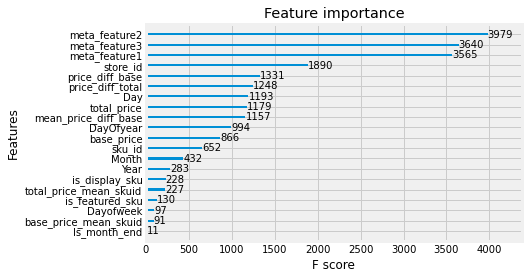

In [34]:
fig = xgb.plot_importance(model2)

In [35]:
prediction = model2.predict(test)
prediction[prediction < 0] = 1
prediction = prediction.reshape((test.shape[0],1))
final = np.concatenate((index, prediction), axis=1)
final = pd.DataFrame(final, columns=['record_ID','units_sold'])

In [36]:
final.to_csv('Submission.csv', index = False)